##### Copyright 2022 Huawei TECHNOLOGIES CO.LTD

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用BSDESolver求解Forward-Backward SDE问题

In [2]:
# !pip install --upgrade mindspore
# !pip install mind-quant-finance

In [3]:
# @title temporary install
!pip install -e. --upgrade

Obtaining file:///home/michael/Documents/MindFinance/mind-quant/mind-quant-finance_1
  Attempting uninstall: MindQuantFinance
    Found existing installation: MindQuantFinance 0.0.1
    Uninstalling MindQuantFinance-0.0.1:
      Successfully uninstalled MindQuantFinance-0.0.1
  Running setup.py develop for MindQuantFinance


In [4]:
#@title Imports

from typing import Optional

import matplotlib.pyplot as plt

import mindspore as ms
import mindspore.numpy as np
from mindspore import nn
from mindspore import dtype as mstype


from mind_quant_finance.engine.nn.bsde_solver import BSDESolver

### Forward-Backward SDE问题定义

Forward-Backward SDE问题(Forward-Backward Stochastic Differential Equation, BSDE)的一般定义为：

设$\{X_t\},\{Y_t\},\{Z_t\}$为待求解的随机过程，若$X_t,Y_t,Z_t$满足以下条件：

$$dX_t = \mu(t,X_t,Y_t,Z_t)dt+\sigma(t,X_t,Y_t)dW_t, t\in [0,T]$$

$$X_0=\xi$$

$$dY_t=\phi(t,X_t,Y_t,Z_t)dt+Z^T\sigma(t,X_t,Y_t)dW_t, t\in[0,T)$$

$$Y_T=g(X_Y)$$

其中$W_t$为标准布朗运动，则称上述问题为Forward-Backward SDE(BSDE)问题。可以看到，BSDE问题由两个SDE等式与两个边界条件组成。其中关于$X_t$的边界条件为其初值$\xi$，而关于$Y_t$的边界条件位于$t=T$，形式为其与$X_T$的关系。


不难发现，大量金融衍生品相关的问题符合BSDE问题的形式。例如，若将标的的价值设为$X_t$，则第一个SDE方程是对标的价值变化的建模，第一个边界条件即标的的初始价值。与之相应的，设$Y_t$为衍生品价值，则第二个SDE方程描述了衍生品的价值变化，而第二个边界条件则为到期日标的与衍生品之间的价值关系。通过求解BSDE方程组，我们可以获得从初始日期到到期日之间任意时刻标的和衍生品的价值。特别的，我们额外关心初始日期时衍生品的价值。

### BSDESolver: 使用神经网络求解BSDE问题

通过一定的数学变换后，BSDE问题可以转化为一个二次PDE问题:

$$p_t = f(t,X,u,Du,D^2u)$$

$$p_t=f(t,x,y,z,\gamma)=\phi(t,x,y,z)-\mu(t,x,y,z)^Tz-\frac{1}{2}Tr[\sigma(t,x,y)\sigma(t,x,y)^T\gamma]$$

其中$D,D^2$表示一阶微分与二阶微分(对$X_t$)，$u=u(t,X_t)$为一个未知解，且满足：

$$u(T,X_T)=g(X_T)$$

显然，$u(T,X_T)$与$Y_t,Z_t$之间的对应关系为：

$$Y_t=u(t,X_t)$$

$$Z_t=Du(t,X_t)$$

简单来说，我们找到了一个特定的解形式，其满足$f(t,X_t,Y_t,Z_t,\gamma)=u(t,X_t,u(t,X_t),Du(t,X_t),\gamma)$。考虑到$u(t,X_t)$是一个未知解，因此我们使用神经网络进行拟合。显然，使用MindSpore的自动微分功能能够很方便的求解$Du(t,X_t)$。然后，我们可以使用Euler-Maruyama范式生成时间序列：

$$\hat{X_{t+\Delta t}}=\hat{X_t} + \mu(t,\hat{X_t},u_t,Du_t)\Delta t + \sigma(t, \hat{X_t},u_t)\Delta W$$

$$\hat{Y_{t+\Delta t}}=\hat{Y_t} + \phi(t,\hat{X_t},u_t,Du_t)\Delta t + (Du_t)^T\sigma(t, \hat{X_t},u_t)\Delta W$$

$$\hat{X_0}=\xi$$

$$\Delta W \sim N(0, \Delta t)$$

损失函数包含两部分，一部分用于衡量边界条件，而另一部分用于衡量路经生成的准确度。设$S$为时间戳集合，$S=[s_1,s_2...s_N]$
，则：

$$Loss = \beta BoundLoss + \sum_{i=1}^{N-1} |dis(s_i)|^2$$

$$BoundLoss=|Y_{s_N}-g(\hat{X_{s_N}})|^2 + |DY_{s_N} - Dg(\hat{X_{s_N}})|^2$$

$$dis(s_i)=(Y_{s_{i+1}}-Y_{s_i})-(\hat{Y_{s_{i+1}}}-\hat{Y_{s_i}})$$


$$Y(s) = u(s, \hat{X_s})$$

其中$\beta$为超参数，用于调整路径生成精度与边界条件满足度之间的权重。

### 案例：Black-Scholes-Barenblatt Equation

Black-Scholes-Barenblatt Equation是一个典型的BSDE问题，其具体形式如下：

$$dX_t = \sigma Diag(X_t)dW_t, t\in[0,T]$$ 

$$X_i=\xi$$ 

$$dY_t=r(Y_t-Z^T_tX_t)dt + \sigma Z_t^T Diag(X_t) dW_t, t\in[0,T)$$

$$Y_T=g(X_T)=||X_T||^2$$

对于Black-Scholes-Barenblatt等式，$u(t,X_t)$有解析解：

$$u(t,X_t)=exp((r+\sigma^2)(T-t))g(x)$$

### 使用MindQuantFinance BSDESolver解决Black-Scholes-Barenblatt Equation in 100D

In [5]:
# class BSDESolver(ABC):
#     def __init__(self, batch_size: int,
#                  terminal_time: float,
#                  n_time: int,
#                  dim: int,
#                  r0: ms.Tensor,
#                  param: Optional[dict] = None,
#                  weight_g: Optional[float] = 1,
#                  net_depth: Optional[int] = 4,
#                  net_hidden_dim: Optional[int] = 256,
#                  net_activation: Optional[nn.Cell] = nn.Tanh(),
#                  net_initializer: Optional[str] = 'Normal',
#                  seed: Optional[int] = 0,
#                  random_type: Optional[int] = 0,
#                  dtype=mstype.float32
#                  ):
#     def get_path_state(self):
#     def train(self, epochs, learning_rate, per_print_times=100, verbose=True):
#     def approximate_path(self, et, ew):  
#     def approximate_solution(self, et, ex): 
#     @abstractmethod
#     def mu_fn(self, t, x, f, grad_f, param): 
#     def sigma_fn(self, t, x, f, param):  
#     def phi_fn(self, t, x, f, grad_f, param): 
#     def g_fn(self, x, param): 

mind_quant_finance中的BSDESolver的结构与方法如上所示。详细的参数含义可以见具体的封装类说明。这里对参数与方法做一个概述。

BSDESolver中比较重要的参数包括：

 - batch_size: 求解时的批大小。
 - terminal_time：终止时间，即BSDE问题中的$T$。
 - n_time: 时间戳的数量。注意$t=0$不包括在其中，$X_0,Y_0$会自动加入生成序列中。
 - dim：随机过程的维度，即$X_t$,$Y_t$,$Z_t$的维度。
 - r0：初始状态$\xi$
 - param：字典，里面包含求解$\mu$, $\sigma$, $\phi$, $g$所需要的自定义工具(具体见后文)。
 - weight_g：损失函数中的权重参数，即损失函数中的$\beta$。
 
BSDESolver中另一个重要的部分是mu_fn, sigma_fn, phi_fn, g_fn。这些函数被设置为一个抽象类。也就是说，当用户使用BSDESolver时，需要自定义BSDESolver的一个子类，并在子类中对上述函数进行具体化。特别的，param字典用于向这些函数中传入必要的求解变量与工具。

下面我们为Black-Scholes-Barenblatt Equation定义BSDESolver的子类BSDESolver_BlackScholesBarenblatt。为了求解方便，先定义两个“工具”，一个是Sin(x)激活函数，另一个用于实现$Diag(X)$操作。

In [6]:
 # This Block is used to generate sin activation function.
class BSDESolver_Sin(nn.Cell):
    def __init__(self):
        super(BSDESolver_Sin, self).__init__()

    def construct(self, x):
        return np.sin(x)


# This Block is used to generate a matrix which can be used in matrix_diag transformation.
class BSDESolver_DiagMatrix:

    def __init__(self, dtype=mstype.float32):
        self.dtype = dtype

    def get_matrix_diag(self, dim, batch):
        # get a matrix to transfer the vector to diag matrix
        # Usage:
        # suppose vec.shape = (batch, D)
        # matrix_diag.shape = (batch, D, D, D)
        # broad_cast: vec_d = (batch, <D>, D, <1>)
        # then MATMUL(matrix_diag, vec_d).shape = (batch, D, D, 1)
        # while (D, D) is the diag matrix
        matrix_diag = np.zeros((dim, dim, dim))
        for i in range(dim):
            matrix_diag[i, i, i] = 1.0
        matrix_diag = np.expand_dims(matrix_diag, axis=0)
        matrix_diag = np.repeat(matrix_diag, batch, axis=0).astype(self.dtype)
        return matrix_diag

设$\sigma$为0.4，$\mu$为0.05，dim为100，batch_size为64，则传入param的工具定义为：

In [7]:
dim = 100
batch_size = 64
diag_matrix_generator = BSDESolver_DiagMatrix()
param_dict = {'matrix_diag': diag_matrix_generator.get_matrix_diag(dim, batch_size),
              'volatility': 0.4, 'no_risk_rate': 0.05}

则根据BlackScholesBarenblatt问题的形式，定义BSDESolver_BlackScholesBarenblatt类如下(具体化$\mu$,$\sigma$,$\phi$,$g$)：

In [8]:
# BSDESolver_BlackScholesBarenblatt Model, Inherited from BSDESolver
class BSDESolver_BlackScholesBarenblatt(BSDESolver):
    def __init__(self, batch_size: int, terminal_time: float, n_time: int,
                 dim: int, r0: ms.Tensor, param: Optional[dict] = None,
                 weight_g: Optional[float] = 1,
                 net_depth: Optional[int] = 4,
                 net_hidden_dim: Optional[int] = 256,
                 net_activation: Optional[nn.Cell] = nn.Tanh(),
                 net_initializer: Optional[str] = 'Normal',
                 seed: Optional[int] = 0,
                 random_type: Optional[int] = 0,
                 dtype=mstype.float32
                 ):
        super().__init__(batch_size, terminal_time, n_time, dim, r0, param, weight_g,
                         net_depth, net_hidden_dim, net_activation, net_initializer,
                         seed, random_type, dtype)
        test_param_keys = ['matrix_diag', 'volatility', 'no_risk_rate']
        for key in test_param_keys:
            if key not in param.keys():
                raise AttributeError("Some Parameter For Calculation Miss.")

    def mu_fn(self, t, x, f, grad, param):
        return np.zeros(x.shape, dtype=self.dtype)

    def sigma_fn(self, t, x, f, param):
        x_d = np.expand_dims(np.expand_dims(x, axis=-1), axis=1)
        x_d = np.repeat(x_d, self.dim, axis=1)
        sigma = np.matmul(param['matrix_diag'], x_d)
        sigma = param['volatility'] * np.squeeze(sigma, axis=-1)
        return sigma

    def phi_fn(self, t, x, f, grad_f, param):
        return param['no_risk_rate'] * (f - np.expand_dims(
            (x * grad_f).sum(axis=1), axis=-1))

    def g_fn(self, x, param):
        return np.expand_dims((x * x).sum(axis=1), axis=1)

我们设置terminal_time为1.0，n_time为50，r0为[1.0, 0.5, 1.0, 0.5....], weight_g为0.1。关于神经网络的结构，我们将其设置为4层MLP，其中隐藏层的维度为512，并使用Sin(x)作为激活函数，XavierUniform进行初始化：

In [9]:
terminal_time = 1.0
n_time = 50
r00 = np.array([1.0, 0.5] * int(dim / 2))[None, :]
weight_g = 0.1
net_depth = 4
net_hidden_dim = 512
net_initializer = 'XavierUniform'
net_activation = BSDESolver_Sin()
bsb_model = BSDESolver_BlackScholesBarenblatt(batch_size=batch_size,
                                              terminal_time=terminal_time, n_time=n_time,
                                              dim=dim, r0=r00, param=param_dict, weight_g=weight_g,
                                              net_depth=net_depth,
                                              net_hidden_dim=net_hidden_dim,
                                              net_activation=net_activation,
                                              net_initializer=net_initializer,
                                              seed=0
                                             )

调用get_path_state()方法即可生成时间戳序列和累加布朗变量序列：

In [10]:
times, ew = bsb_model.get_path_state()
print(ew.shape)
print(ew[0,0,:10])

(64, 51, 100)
[ 0.03560384  0.02463679  0.15634952 -0.05092085 -0.07928148 -0.04546742
  0.01190416  0.11251857  0.09321497 -0.05842454]


设置训练的epochs数以及学习率lr，调用train()方法即可开始训练。

In [11]:
# 2-WARNING ; 3-ERROR
!export GLOG_v=3

In [12]:
epochs = 5000
lr = nn.cosine_decay_lr(min_lr=1e-9, max_lr=2e-4, total_step=epochs, 
                        step_per_epoch=1, decay_epoch=epochs-500)
bsb_model.train(epochs=epochs, learning_rate=lr, per_print_times=250, verbose=True)
epochs = 1000
lr = nn.cosine_decay_lr(min_lr=1e-9, max_lr=1e-5, total_step=epochs, 
                        step_per_epoch=1, decay_epoch=epochs)
bsb_model.train(epochs=epochs, learning_rate=lr, per_print_times=100, verbose=True)

[WARNING] OPTIMIZER(5157,7f4ea5abc740,python):2022-12-08-15:47:09.420.186 [mindspore/ccsrc/frontend/optimizer/ad/dfunctor.cc:875] GetPrimalUser] It is recommended to call the forward network only once.
[WARNING] OPTIMIZER(5157,7f4ea5abc740,python):2022-12-08-15:47:09.420.207 [mindspore/ccsrc/frontend/optimizer/ad/dfunctor.cc:875] GetPrimalUser] It is recommended to call the forward network only once.
[WARNING] OPTIMIZER(5157,7f4ea5abc740,python):2022-12-08-15:47:09.420.210 [mindspore/ccsrc/frontend/optimizer/ad/dfunctor.cc:875] GetPrimalUser] It is recommended to call the forward network only once.
[WARNING] OPTIMIZER(5157,7f4ea5abc740,python):2022-12-08-15:47:09.420.213 [mindspore/ccsrc/frontend/optimizer/ad/dfunctor.cc:875] GetPrimalUser] It is recommended to call the forward network only once.
[WARNING] OPTIMIZER(5157,7f4ea5abc740,python):2022-12-08-15:47:09.420.215 [mindspore/ccsrc/frontend/optimizer/ad/dfunctor.cc:875] GetPrimalUser] It is recommended to call the forward network o

Epoch: [0 / 5000] loss: 37549.863 learning_rate=0.0002
Epoch: [250 / 5000] loss: 15827.329 learning_rate=0.00019848078289734432
Epoch: [500 / 5000] loss: 7180.7334 learning_rate=0.00019396929223228045
Epoch: [750 / 5000] loss: 3005.7869 learning_rate=0.000186602607365742
Epoch: [1000 / 5000] loss: 1463.0887 learning_rate=0.00017660456128967624
Epoch: [1250 / 5000] loss: 724.5117 learning_rate=0.0001642789395748491
Epoch: [1500 / 5000] loss: 589.81616 learning_rate=0.00015000025000000002
Epoch: [1750 / 5000] loss: 312.9575 learning_rate=0.00013420234332249523
Epoch: [2000 / 5000] loss: 262.45563 learning_rate=0.00011736523094260423
Epoch: [2250 / 5000] loss: 194.96652 learning_rate=0.00010000050000000001
Epoch: [2500 / 5000] loss: 108.549515 learning_rate=8.263576905739581e-05
Epoch: [2750 / 5000] loss: 108.40695 learning_rate=6.579865667750482e-05
Epoch: [3000 / 5000] loss: 80.30163 learning_rate=5.000075000000003e-05
Epoch: [3250 / 5000] loss: 94.54365 learning_rate=3.5722060425150914

[WARNING] OPTIMIZER(5157,7f4ea5abc740,python):2022-12-08-16:41:01.878.745 [mindspore/ccsrc/frontend/optimizer/ad/dfunctor.cc:875] GetPrimalUser] It is recommended to call the forward network only once.
[WARNING] OPTIMIZER(5157,7f4ea5abc740,python):2022-12-08-16:41:01.878.770 [mindspore/ccsrc/frontend/optimizer/ad/dfunctor.cc:875] GetPrimalUser] It is recommended to call the forward network only once.
[WARNING] OPTIMIZER(5157,7f4ea5abc740,python):2022-12-08-16:41:01.878.773 [mindspore/ccsrc/frontend/optimizer/ad/dfunctor.cc:875] GetPrimalUser] It is recommended to call the forward network only once.
[WARNING] OPTIMIZER(5157,7f4ea5abc740,python):2022-12-08-16:41:01.878.776 [mindspore/ccsrc/frontend/optimizer/ad/dfunctor.cc:875] GetPrimalUser] It is recommended to call the forward network only once.
[WARNING] OPTIMIZER(5157,7f4ea5abc740,python):2022-12-08-16:41:01.878.779 [mindspore/ccsrc/frontend/optimizer/ad/dfunctor.cc:875] GetPrimalUser] It is recommended to call the forward network o

Epoch: [0 / 1000] loss: 190.46864 learning_rate=1e-05
Epoch: [100 / 1000] loss: 66.27594 learning_rate=9.755307053217622e-06
Epoch: [200 / 1000] loss: 106.11043 learning_rate=9.04518046337755e-06
Epoch: [300 / 1000] loss: 73.14998 learning_rate=7.93913236883622e-06
Epoch: [400 / 1000] loss: 88.20503 learning_rate=6.54543046337755e-06
Epoch: [500 / 1000] loss: 86.89305 learning_rate=5.0005e-06
Epoch: [600 / 1000] loss: 63.542793 learning_rate=3.455569536622451e-06
Epoch: [700 / 1000] loss: 65.06239 learning_rate=2.061867631163781e-06
Epoch: [800 / 1000] loss: 173.83148 learning_rate=9.558195366224508e-07
Epoch: [900 / 1000] loss: 53.055748 learning_rate=2.4569294678237995e-07


In [13]:
ms.save_checkpoint(bsb_model.sde_path.sde_net, 'src/bsde_bsb_model_100d_4sin2_64_512.ckpt')

In [14]:
net_param_dict = ms.load_checkpoint("src/bsde_bsb_model_100d_4sin2_64_512.ckpt")
ms.load_param_into_net(bsb_model.sde_path.sde_net, net_param_dict)

[]

### 推理与评估

在训练结束后，给定任意时间戳和累计布朗运动训练，通过调用approximate_path()，即可获得$X_t$和$Y_t$的时间序列。

In [15]:
obj, der, der_price = bsb_model.approximate_path(times, ew)  # (batch, t+1, 1), (batch, t+1, dim)

我们利用BlackScholesBarenblatt的解析解对训练的结果进行验证。

In [16]:
def bsb_exact(t, x):  # (n2_time+1, 1), (n2_time+1, dim)
    r = param_dict['no_risk_rate']
    sigma_max = param_dict['volatility']
    return np.exp((r + (sigma_max ** 2)) * (terminal_time - t)) * np.expand_dims((x ** 2).sum(axis=1), axis=1)
    # (n_time+1, 1)

ground_der = bsb_exact(np.reshape(times, (-1, 1)), np.reshape(obj, (-1, dim))).\
                reshape(batch_size, n_time + 1, 1)

将其可视化如下：

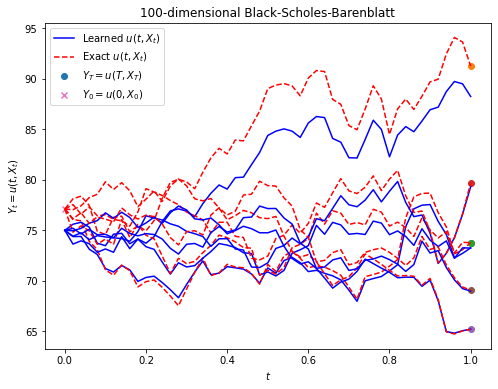

In [19]:
n_display = 6
fig = plt.figure(figsize=(8, 6))
plt.plot(times[0, :, 0].asnumpy(), der[0, :, 0].asnumpy(), color='b', label='Learned $u(t,X_t)$')
plt.plot(times[0, :, 0].asnumpy(), ground_der[0, :, 0].asnumpy(), color='r', linestyle='--',
        label='Exact $u(t,X_t)$')
plt.scatter(times[0:1, -1, 0].asnumpy(), ground_der[0:1, -1, 0].asnumpy(), marker='o', label='$Y_T = u(T,X_T)$')
for i in range(1, n_display):
    plt.plot(times[i, :, 0].asnumpy(), der[i, :, 0].asnumpy(), color='b')
    plt.plot(times[i, :, 0].asnumpy(), ground_der[i, :, 0].asnumpy(), color='r', linestyle='--')
    plt.scatter(times[i:i + 1, -1, 0].asnumpy(), ground_der[i:i + 1, -1, 0].asnumpy(), marker='o')
plt.scatter(ms.Tensor([0]).asnumpy(), ground_der[0:1, 0, 0].asnumpy(), marker='x', label='$Y_0 = u(0,X_0)$')
plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title('100-dimensional Black-Scholes-Barenblatt')
plt.legend()

最后，我们求解相对误差，以直观的展现误差在生成序列中的分布状况：

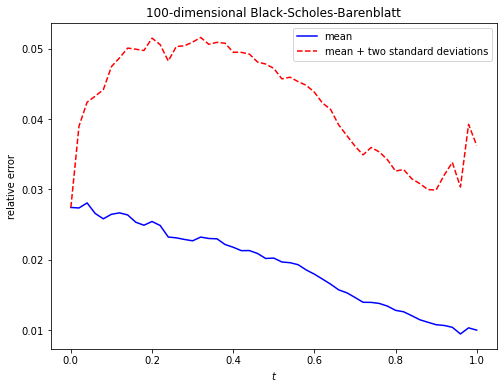

In [18]:
errors = np.sqrt((ground_der - der) ** 2 / ground_der ** 2)
mean_errors = np.mean(errors, 0)
std_errors = np.std(errors, 0)
fig = plt.figure(figsize=(8, 6))
plt.plot(times[0, :, 0].asnumpy(), mean_errors.asnumpy(), color='b', label='mean')
plt.plot(times[0, :, 0].asnumpy(), mean_errors.asnumpy() + 2 * std_errors.asnumpy(), color='r', linestyle='--',
        label='mean + two standard deviations')
plt.xlabel('$t$')
plt.ylabel('relative error')
plt.title('100-dimensional Black-Scholes-Barenblatt')
plt.legend()
plt.show()

可以看到，我们对初始时刻$Y_0$的估计相对误差在3\%左右，故模型成功实现了对BSDE问题的求解。